In [1]:
# install libraries if not already installed, uncomment the following lines

import sys
# !{sys.executable} -m pip install opencv-python opencv-contrib-python matplotlib numpy torch torchvision pandas tqdm scikit-learn seaborn transformers datasets accelerate

In [2]:
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch


/Users/tommytran/PycharmProjects/ComputerVision/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
from src import dataloader as ds
from src import models as m
from src import training as t
from src import evaluation as eval


In [4]:
file_path = 'fer2013.tar.gz'
data_path = ds.unpack_tar_gz(file_path)

Target folder 'data' is not empty. Assuming the file is already unpacked.


In [5]:
# dataset is available at https://www.kaggle.com/datasets/ashishpatel26/facial-expression-recognitionferchallenge
df = pd.read_csv(data_path)
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
emotion_label = {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [7]:
df_mapped = df.copy()

# Map the emotion labels to their names
df_mapped['emotion'] = df_mapped['emotion'].map(emotion_label)

In [8]:
df_mapped.head()

,emotion,pixels,Usage
0,anger,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,anger,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,fear,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,sadness,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,neutral,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [9]:
df_mapped['Usage'].value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [10]:
df_mapped['emotion'].value_counts()
# get class weights of the training set

emotion
happiness    8989
neutral      6198
sadness      6077
fear         5121
anger        4953
surprise     4002
disgust       547
Name: count, dtype: int64

In [11]:
train_class_weights = df_mapped[df_mapped['Usage'] == 'Training']['emotion'].value_counts(normalize=True)
train_class_weights

emotion
happiness    0.251315
neutral      0.172942
sadness      0.168240
fear         0.142708
anger        0.139155
surprise     0.110453
disgust      0.015187
Name: proportion, dtype: float64

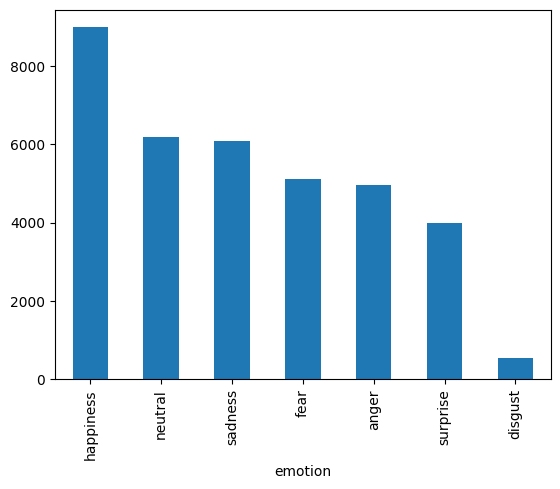

In [12]:
# plot the distribution of the emotions
df_mapped['emotion'].value_counts().plot(kind='bar')
plt.show()

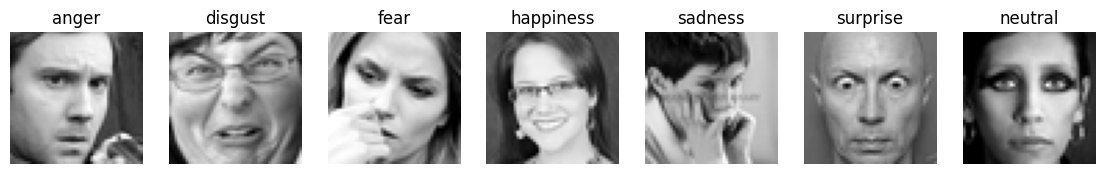

In [13]:
def pixels_to_image(pixels_str):
    pixels = np.fromstring(pixels_str, dtype=int, sep=' ')
    image = pixels.reshape(48, 48)
    return image


# plot each emotion
fig, axes = plt.subplots(1, 7, figsize=(14, 2))
for i in range(7):
    image = pixels_to_image(df[df['emotion'] == i].iloc[0]['pixels'])
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(emotion_label[i])
    axes[i].axis('off')

plt.show()

In [14]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
    transforms.RandomRotation(degrees=10),  # Randomly rotate the image by up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    # Randomly change brightness, contrast, and saturation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

batch_size = 32
train_loader, valid_loader, test_loader = ds.get_data_loaders(data_path, batch_size, train_transform)

Loaded 28709 samples for mode 'train'
Loaded 3589 samples for mode 'val'
Loaded 3589 samples for mode 'test'


In [15]:
class_counts = df[df['Usage'] == 'Training']['emotion'].value_counts()
class_counts=class_counts.sort_index()
train_class_weights = 1.0 / class_counts.values
train_class_weights = train_class_weights / np.sum(train_class_weights)
print(train_class_weights)
train_class_weights = torch.from_numpy(train_class_weights).float()

[0.06857175 0.62831226 0.06686457 0.0379687  0.05671721 0.08639046
 0.05517505]


Validation: 100%|██████████| 113/113 [00:01<00:00, 92.79it/s, Val Loss=0.054, Accuracy=36.6] 


Epoch 1/10, Train Loss: 1.8581, Train Acc: 25.1837, Val Loss: 1.7158, Val Acc: 36.6397
Best model saved with accuracy: 36.6397 as 'bestmodels/Final_SimpleCNN_CrossEntropyLoss_Adam_best_model.pth'


Validation: 100%|██████████| 113/113 [00:01<00:00, 94.96it/s, Val Loss=0.0509, Accuracy=40.1]


Epoch 2/10, Train Loss: 1.7274, Train Acc: 33.1917, Val Loss: 1.6167, Val Acc: 40.0947
Best model saved with accuracy: 40.0947 as 'bestmodels/Final_SimpleCNN_CrossEntropyLoss_Adam_best_model.pth'


Validation: 100%|██████████| 113/113 [00:01<00:00, 94.28it/s, Val Loss=0.0487, Accuracy=40]  


Epoch 3/10, Train Loss: 1.6601, Train Acc: 35.9817, Val Loss: 1.5460, Val Acc: 39.9554


Validation: 100%|██████████| 113/113 [00:01<00:00, 94.84it/s, Val Loss=0.0469, Accuracy=42.7]


Epoch 4/10, Train Loss: 1.6147, Train Acc: 37.9045, Val Loss: 1.4885, Val Acc: 42.6860
Best model saved with accuracy: 42.6860 as 'bestmodels/Final_SimpleCNN_CrossEntropyLoss_Adam_best_model.pth'


Validation: 100%|██████████| 113/113 [00:01<00:00, 94.40it/s, Val Loss=0.0458, Accuracy=45.3]


Epoch 5/10, Train Loss: 1.5813, Train Acc: 38.5036, Val Loss: 1.4559, Val Acc: 45.2772
Best model saved with accuracy: 45.2772 as 'bestmodels/Final_SimpleCNN_CrossEntropyLoss_Adam_best_model.pth'


Validation: 100%|██████████| 113/113 [00:01<00:00, 95.07it/s, Val Loss=0.0452, Accuracy=44.7]


Epoch 6/10, Train Loss: 1.5657, Train Acc: 39.3605, Val Loss: 1.4359, Val Acc: 44.6921


Validation: 100%|██████████| 113/113 [00:01<00:00, 94.07it/s, Val Loss=0.0453, Accuracy=47.2]


Epoch 7/10, Train Loss: 1.5378, Train Acc: 40.5552, Val Loss: 1.4383, Val Acc: 47.2276
Best model saved with accuracy: 47.2276 as 'bestmodels/Final_SimpleCNN_CrossEntropyLoss_Adam_best_model.pth'


Validation: 100%|██████████| 113/113 [00:01<00:00, 95.06it/s, Val Loss=0.0451, Accuracy=45.8]


Epoch 8/10, Train Loss: 1.5357, Train Acc: 40.4054, Val Loss: 1.4315, Val Acc: 45.7788


Validation: 100%|██████████| 113/113 [00:01<00:00, 94.48it/s, Val Loss=0.0446, Accuracy=47.6]


Epoch 9/10, Train Loss: 1.5155, Train Acc: 41.2170, Val Loss: 1.4165, Val Acc: 47.5620
Best model saved with accuracy: 47.5620 as 'bestmodels/Final_SimpleCNN_CrossEntropyLoss_Adam_best_model.pth'


Validation: 100%|██████████| 113/113 [00:01<00:00, 94.44it/s, Val Loss=0.0449, Accuracy=46.3]


Epoch 10/10, Train Loss: 1.4998, Train Acc: 41.6106, Val Loss: 1.4259, Val Acc: 46.3082


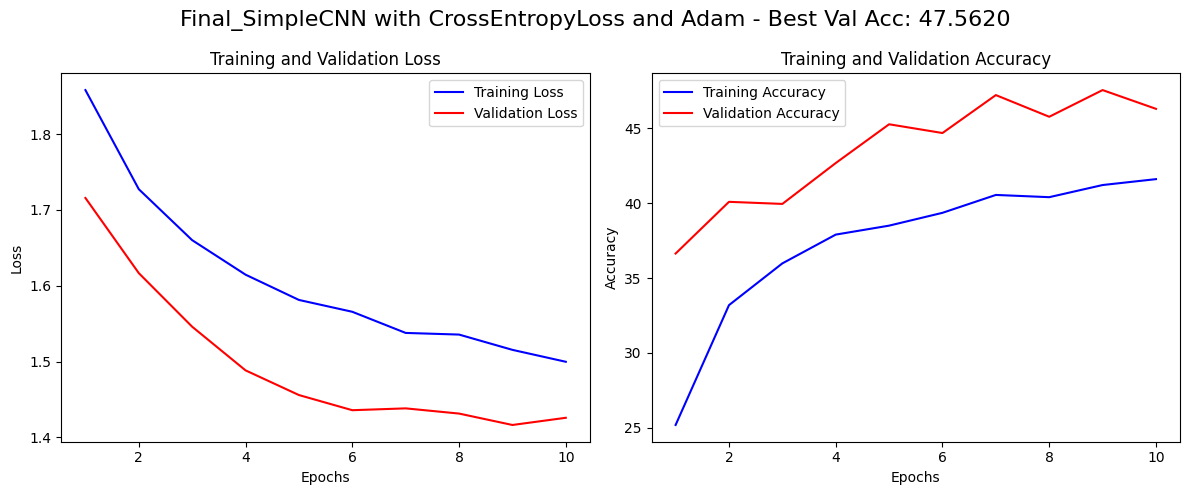

In [16]:
model = m.Final_SimpleCNN()
criteria = torch.nn.CrossEntropyLoss(weight=train_class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
t.train(model, train_loader, valid_loader, criteria, optimizer, num_epochs=10)

Evaluating: 100%|██████████| 113/113 [00:01<00:00, 104.98it/s]


Test Loss: 1.3877, Test Accuracy: 47.4784%


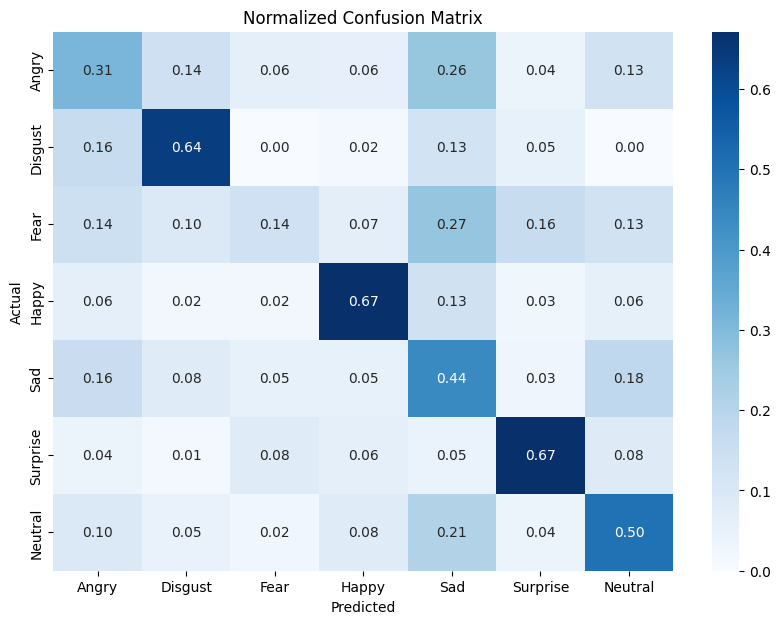

Classification Report:

              precision    recall  f1-score   support

       Angry       0.33      0.31      0.32       491
     Disgust       0.14      0.64      0.22        55
        Fear       0.35      0.14      0.20       528
       Happy       0.77      0.67      0.72       879
         Sad       0.32      0.44      0.37       594
    Surprise       0.62      0.67      0.64       416
     Neutral       0.49      0.50      0.50       626

    accuracy                           0.47      3589
   macro avg       0.43      0.48      0.42      3589
weighted avg       0.50      0.47      0.47      3589


In [17]:
# Evaluate the model
criterion = torch.nn.CrossEntropyLoss()
eval.evaluate_model(model, test_loader, criterion)

Validation: 100%|██████████| 113/113 [00:02<00:00, 41.27it/s, Val Loss=0.0606, Accuracy=17.4]


Epoch 1/10, Train Loss: 1.9372, Train Acc: 18.2904, Val Loss: 1.9239, Val Acc: 17.3586
Best model saved with accuracy: 17.3586 as 'bestmodels/Final_IntermediateCNN_CrossEntropyLoss_Adam_best_model.pth'


Validation: 100%|██████████| 113/113 [00:02<00:00, 40.93it/s, Val Loss=0.0543, Accuracy=33.3]


Epoch 2/10, Train Loss: 1.8547, Train Acc: 25.2221, Val Loss: 1.7254, Val Acc: 33.3240
Best model saved with accuracy: 33.3240 as 'bestmodels/Final_IntermediateCNN_CrossEntropyLoss_Adam_best_model.pth'


Validation: 100%|██████████| 113/113 [00:02<00:00, 41.31it/s, Val Loss=0.0487, Accuracy=41.7]


Epoch 3/10, Train Loss: 1.6757, Train Acc: 35.3757, Val Loss: 1.5454, Val Acc: 41.6551
Best model saved with accuracy: 41.6551 as 'bestmodels/Final_IntermediateCNN_CrossEntropyLoss_Adam_best_model.pth'


Validation: 100%|██████████| 113/113 [00:02<00:00, 40.29it/s, Val Loss=0.0461, Accuracy=43.5]


Epoch 4/10, Train Loss: 1.5612, Train Acc: 40.7921, Val Loss: 1.4645, Val Acc: 43.5497
Best model saved with accuracy: 43.5497 as 'bestmodels/Final_IntermediateCNN_CrossEntropyLoss_Adam_best_model.pth'


Validation: 100%|██████████| 113/113 [00:02<00:00, 39.47it/s, Val Loss=0.0455, Accuracy=45.9]


Epoch 5/10, Train Loss: 1.5017, Train Acc: 43.0318, Val Loss: 1.4444, Val Acc: 45.9181
Best model saved with accuracy: 45.9181 as 'bestmodels/Final_IntermediateCNN_CrossEntropyLoss_Adam_best_model.pth'


Validation: 100%|██████████| 113/113 [00:02<00:00, 40.75it/s, Val Loss=0.0444, Accuracy=44.9]


Epoch 6/10, Train Loss: 1.4497, Train Acc: 44.4843, Val Loss: 1.4098, Val Acc: 44.8593


Validation: 100%|██████████| 113/113 [00:02<00:00, 40.89it/s, Val Loss=0.0436, Accuracy=48.1]


Epoch 7/10, Train Loss: 1.4150, Train Acc: 46.2886, Val Loss: 1.3833, Val Acc: 48.0635
Best model saved with accuracy: 48.0635 as 'bestmodels/Final_IntermediateCNN_CrossEntropyLoss_Adam_best_model.pth'


Validation: 100%|██████████| 113/113 [00:02<00:00, 41.01it/s, Val Loss=0.0432, Accuracy=49.8]


Epoch 8/10, Train Loss: 1.3928, Train Acc: 46.8250, Val Loss: 1.3721, Val Acc: 49.8189
Best model saved with accuracy: 49.8189 as 'bestmodels/Final_IntermediateCNN_CrossEntropyLoss_Adam_best_model.pth'


Validation: 100%|██████████| 113/113 [00:02<00:00, 40.47it/s, Val Loss=0.0435, Accuracy=50]  


Epoch 9/10, Train Loss: 1.3722, Train Acc: 47.4764, Val Loss: 1.3828, Val Acc: 49.9861
Best model saved with accuracy: 49.9861 as 'bestmodels/Final_IntermediateCNN_CrossEntropyLoss_Adam_best_model.pth'


Validation: 100%|██████████| 113/113 [00:06<00:00, 17.91it/s, Val Loss=0.0419, Accuracy=50]  


Epoch 10/10, Train Loss: 1.3550, Train Acc: 48.2915, Val Loss: 1.3308, Val Acc: 49.9582


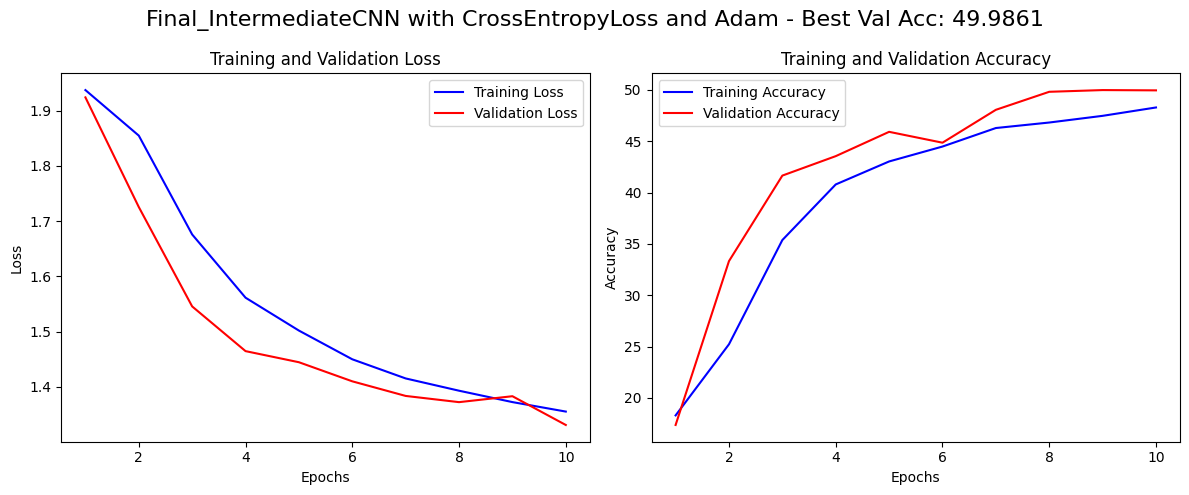

In [18]:
model = m.Final_IntermediateCNN()
criteria = torch.nn.CrossEntropyLoss(weight=train_class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
t.train(model, train_loader, valid_loader, criteria, optimizer, num_epochs=10)

Evaluating: 100%|██████████| 113/113 [00:03<00:00, 34.90it/s]


Test Loss: 1.3047, Test Accuracy: 50.2368%


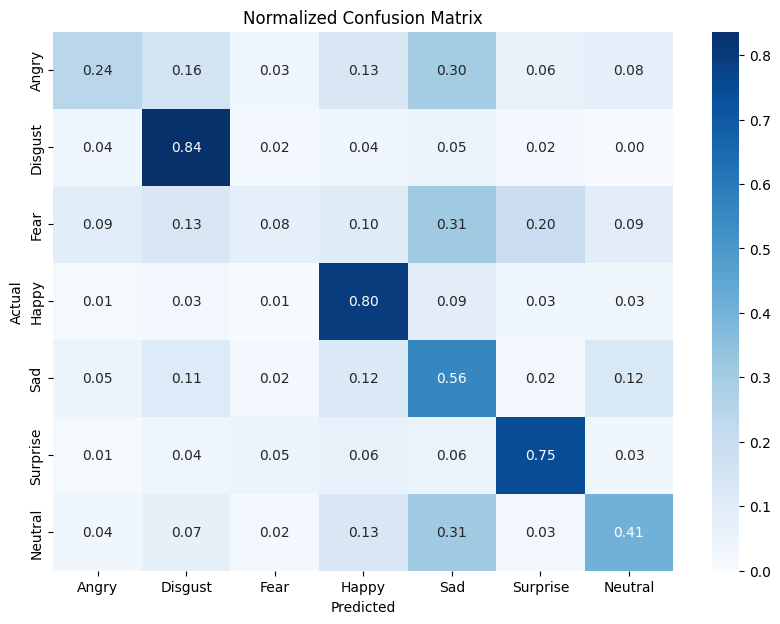

Classification Report:

              precision    recall  f1-score   support

       Angry       0.50      0.24      0.33       491
     Disgust       0.14      0.84      0.23        55
        Fear       0.36      0.08      0.13       528
       Happy       0.70      0.80      0.75       879
         Sad       0.35      0.56      0.43       594
    Surprise       0.62      0.75      0.68       416
     Neutral       0.56      0.41      0.47       626

    accuracy                           0.50      3589
   macro avg       0.46      0.52      0.43      3589
weighted avg       0.52      0.50      0.48      3589


In [19]:
# Evaluate the model
criterion = torch.nn.CrossEntropyLoss()
eval.evaluate_model(model, test_loader, criterion)

Validation: 100%|██████████| 113/113 [00:06<00:00, 16.19it/s, Val Loss=0.061, Accuracy=25.2] 


Epoch 1/10, Train Loss: 1.9590, Train Acc: 18.2695, Val Loss: 1.9369, Val Acc: 25.2438
Best model saved with accuracy: 25.2438 as 'bestmodels/Final_ComplexCNN_CrossEntropyLoss_Adam_best_model.pth'


Validation: 100%|██████████| 113/113 [00:07<00:00, 16.05it/s, Val Loss=0.0611, Accuracy=25.2]


Epoch 2/10, Train Loss: 1.9418, Train Acc: 19.2588, Val Loss: 1.9393, Val Acc: 25.2438


Validation: 100%|██████████| 113/113 [00:07<00:00, 16.02it/s, Val Loss=0.0609, Accuracy=15.5]


Epoch 3/10, Train Loss: 1.9400, Train Acc: 17.6112, Val Loss: 1.9334, Val Acc: 15.5475


Validation: 100%|██████████| 113/113 [00:07<00:00, 16.10it/s, Val Loss=0.0609, Accuracy=17.4]


Epoch 4/10, Train Loss: 1.9430, Train Acc: 14.3161, Val Loss: 1.9327, Val Acc: 17.4143


Validation: 100%|██████████| 113/113 [00:07<00:00, 16.10it/s, Val Loss=0.0609, Accuracy=14.8]


Epoch 5/10, Train Loss: 1.9380, Train Acc: 15.1277, Val Loss: 1.9327, Val Acc: 14.7673


Validation: 100%|██████████| 113/113 [00:07<00:00, 15.91it/s, Val Loss=0.0606, Accuracy=14.4]


Epoch 6/10, Train Loss: 1.9365, Train Acc: 17.3534, Val Loss: 1.9245, Val Acc: 14.4051


Validation: 100%|██████████| 113/113 [00:06<00:00, 16.15it/s, Val Loss=0.0593, Accuracy=23.7]


Epoch 7/10, Train Loss: 1.9228, Train Acc: 19.2065, Val Loss: 1.8844, Val Acc: 23.6835


Validation: 100%|██████████| 113/113 [00:07<00:00, 15.96it/s, Val Loss=0.0541, Accuracy=30.3]


Epoch 8/10, Train Loss: 1.8367, Train Acc: 25.7933, Val Loss: 1.7185, Val Acc: 30.2870
Best model saved with accuracy: 30.2870 as 'bestmodels/Final_ComplexCNN_CrossEntropyLoss_Adam_best_model.pth'


Validation: 100%|██████████| 113/113 [00:07<00:00, 15.95it/s, Val Loss=0.0511, Accuracy=34.5]


Epoch 9/10, Train Loss: 1.7298, Train Acc: 31.1366, Val Loss: 1.6222, Val Acc: 34.4943
Best model saved with accuracy: 34.4943 as 'bestmodels/Final_ComplexCNN_CrossEntropyLoss_Adam_best_model.pth'


Validation: 100%|██████████| 113/113 [00:07<00:00, 16.01it/s, Val Loss=0.0489, Accuracy=37.3]


Epoch 10/10, Train Loss: 1.6274, Train Acc: 37.5422, Val Loss: 1.5538, Val Acc: 37.2806
Best model saved with accuracy: 37.2806 as 'bestmodels/Final_ComplexCNN_CrossEntropyLoss_Adam_best_model.pth'


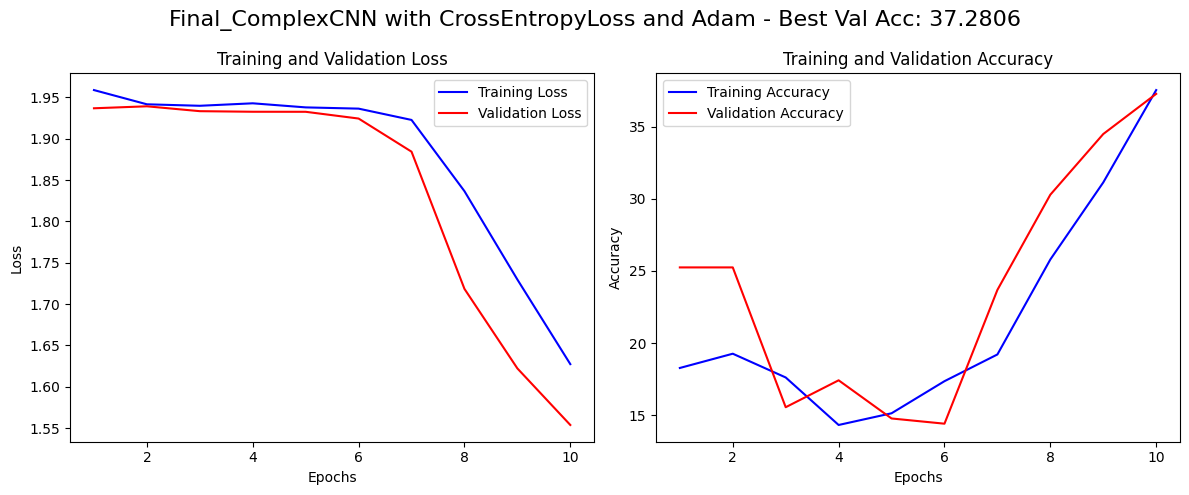

In [20]:
model = m.Final_ComplexCNN()
criteria = torch.nn.CrossEntropyLoss(weight=train_class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
t.train(model, train_loader, valid_loader, criteria, optimizer, num_epochs=10)

Evaluating: 100%|██████████| 113/113 [00:06<00:00, 16.35it/s]


Test Loss: 1.5996, Test Accuracy: 37.1691%


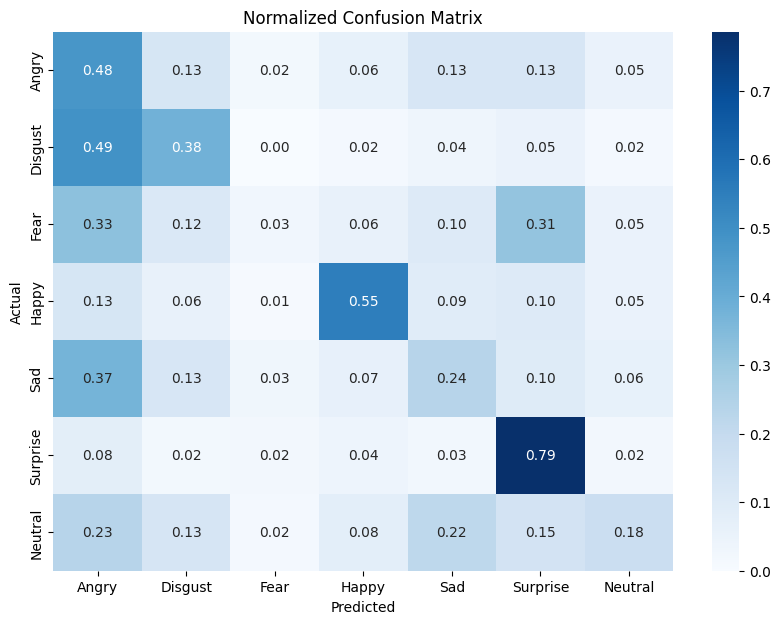

Classification Report:

              precision    recall  f1-score   support

       Angry       0.25      0.48      0.33       491
     Disgust       0.06      0.38      0.10        55
        Fear       0.21      0.03      0.05       528
       Happy       0.74      0.55      0.63       879
         Sad       0.29      0.24      0.26       594
    Surprise       0.41      0.79      0.54       416
     Neutral       0.42      0.18      0.25       626

    accuracy                           0.37      3589
   macro avg       0.34      0.38      0.31      3589
weighted avg       0.42      0.37      0.36      3589


In [21]:
# Evaluate the model
criterion = torch.nn.CrossEntropyLoss()
eval.evaluate_model(model, test_loader, criterion)

In [ ]:
# use saved model
criterion = torch.nn.CrossEntropyLoss()
model = m.load_model(m.SimpleCNN(), 'bestmodels/SimpleCNN_CrossEntropyLoss_Adam_best_model.pth')
eval.evaluate_model(model, test_loader, criterion)

In [ ]:
for i in range(7):
    for image, label in test_loader:
        if label[0] == i:
            input_image = image[0]
            eval.plot_activations(model, input_image, emotion_label[i])
            break